# Applicability and interpretation of the deterministic weighted cepstral distance: Numerical Illustrations

This notebook serves as a companion to the manuscript "Applicability and interpretation of the deterministic weighted cepstral distance", a copy of which can be found here [ADD LINK]. The results discussed and proven in the paper will be illustrated here via numerical examples. It is also possible - and encouraged - to try out other systems, inputs, ..., than the particular ones provided here.

Note that the examples here are for model norms. The distance between two models with transfer functions *H<sub>1</sub>* and *H<sub>2</sub>* can be calculated as the norm of the model with transfer function *H<sub>1</sub>H<sub>2</sub><sup>-1</sup>*.

## Defining functions

First, we define several functions and import necessary packages that will prove useful later on.

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import scipy.signal as sps
import matplotlib.pyplot as plt

def hankel(ts,k):
    # hankel expects a time series (ts), and a size (k), and returns a hankel matrix, built from the time series,
    # of size (len(ts)-k+1,k).
    n = int(np.floor(ts.shape[0]))
    H = sp.linalg.hankel(ts[0:n-k+1],ts[n-k:])
    # The transpose is a matter of convention, and is important for the formulas in subspace_angles, which we could
    # rewrite to employ H in stead of the transpose of H.
    return np.transpose(H)

def subspace_angles(u,y):
    # subspace_angles expects the time domain information (i.e. the raw signal) of input (u) and output (y),
    # and returns an array with the cosines of the subspace angles associated with the model.
    max_k = 2**10
    k=int(np.floor(np.minimum(len(u),max_k)/4)) # Choose the size of the Hankel matrices
    U = hankel(u[:np.minimum(N,max_k)],k)       # Initialize Hankel matrices
    Y = hankel(y[:np.minimum(N,max_k)],k)

    projectorU = np.dot(np.dot(np.transpose(U),np.linalg.pinv(np.dot(U,np.transpose(U)))),U)  # Build porjector matrices
    dimU = projectorU.shape[0]
    projectorY = np.dot(np.dot(np.transpose(Y),np.linalg.pinv(np.dot(Y,np.transpose(Y)))),Y)
    dimY = projectorY.shape[0]
    
    Gamma = np.dot(Y,(np.identity(dimU)-projectorU))      # Estimate the range of the observability matrices.
    Gamma = np.transpose(Gamma)
    GammaInv = np.dot(U,(np.identity(dimY)-projectorY))
    GammaInv = np.transpose(GammaInv)

    # Find the square roots of the eigenvalues of equation (36) in the manuscript, by calculating the svd.
    s = np.linalg.svd(np.dot(np.dot(np.dot(np.transpose(Gamma),np.linalg.pinv(np.dot(Gamma,np.transpose(Gamma)))),Gamma),np.dot(np.dot(np.transpose(GammaInv),np.linalg.pinv(np.dot(GammaInv,np.transpose(GammaInv)))),GammaInv)),compute_uv=0)
    s_significant = [i for i in s if i >= 10**(-9)]
    # Return all significant singular values (i.e. significantly larger than machine precision). The amount of
    # significant values coincides with the order of the model. See "[6] Katrien De Cock. Principal angles in
    # system theory, information theory and signal processing. PhD thesis.", for a discussion.
    return s_significant

def FORSE(frequ,freqy,wu):
    # We implement the FORSE algorithm described in "[12] Ketao Liu, Robert N Jacques, and David W. Miller.
    # Frequency domain structural system identification by observability range space extraction. Journal of
    # Dynamic Systems, 118:211, 1996.". This algorithm is not very robust agains poles or zeros near the unit circle.
    z = np.exp(1j*(wu))
    q = int(np.floor(np.minimum(len(frequ)/2,2**8)))
    exponents = np.arange(0,q)
    U = np.matrix(np.multiply(np.array([z**x for x in exponents]),frequ))
    Y = np.matrix(np.multiply(np.array([z**x for x in exponents]),freqy))

    u,s,v = np.linalg.svd((np.dot(Y,Y.getH()).real).A - np.dot(np.dot(Y,(U.getH())).real,np.dot(np.linalg.pinv(np.dot(U,U.getH()).real),np.dot(Y,U.getH()).getT().real).real).A)
    u_inv,s_inv,v_inv = np.linalg.svd((np.dot(U,U.getH()).real).A - np.dot(np.dot(U,(Y.getH())).real,np.dot(np.linalg.pinv(np.dot(Y,Y.getH()).real),(np.dot(U,Y.getH()).getT().real)).real).A)
    
    
    order = np.minimum(len([i for i in s if i >= s[0]*(10**(-5))]),len([i for i in s_inv if i >= s_inv[0]*(10**(-5))]))
    
    Gamma = np.transpose(u[:,:order])
    GammaInv = np.transpose(u_inv[:,:order])
    cosangles = np.linalg.svd(np.dot(np.dot(np.dot(np.transpose(Gamma),np.linalg.pinv(np.dot(Gamma,np.transpose(Gamma)))),Gamma),np.dot(np.dot(np.transpose(GammaInv),np.linalg.pinv(np.dot(GammaInv,np.transpose(GammaInv)))),GammaInv)),compute_uv=0)

    cosangles_significant = [i for i in cosangles if i >= 10**(-9)]
    
    return cosangles_significant

def complex_cepstrum(specu,specy):
    # complex_cepstrum expects the spectra of the input (specu) and output (specy) data.
    # It calculates the complex cepstral coefficients of the underlying model,
    # and returns the positive and negative part seperately.
    # The subtraction of output cepstrum and input cepstrum is moved through the ifft and the logarithm,
    # changing into a division in frequency domain, to improve numerical stability.
    # This does not change the theoretical results.
    
    spec = specy/specu                                  # Divide the spectrum of the output with that of the input
                                                        # to extract the information about the underlying system.
        
    angles= np.unwrap(np.angle(spec))       # Calculate the complex logarithm.
    hat = np.log(np.abs(spec)) + 1j*(angles)
    
    ceps = np.fft.ifft(hat).real                        # Calculate the complex cepstrum.
    
    # The positive coefficients of the complex cepstrum, denoted posceps, are associated with the minimum-phase
    # part of the signal, the negative coefficients are associated with the maximum-phase part, as discussed in
    # the manuscript, section "6 Assesing phase-type of systems". Both are returned seperately.
    
    posceps = ceps[0:int(np.floor(ceps.shape[0]/2))]
    negceps = ceps[::-1]
    negceps = np.append(ceps[0],negceps[0:int(np.floor(ceps.shape[0]/2 - 1))])

    return posceps, negceps

def power_cepstrum(u,y):
    # power_cepstrum expects the time domain information of input (u) and output (y), as it will calculate the
    # power spectral density (psd) using Welch's method, which provides a better estimate of the psd
    # than the naive fft-implementation. power_cepstrum then returns the power cepstrum of the underlying model.
    # The subtracton of output and input power cepstrum is again changed into a division in the frequency 
    # domain (see complex_cepstrum).
    windowsize = np.minimum(N,np.maximum(256,int(np.floor(N/4))))     # Define a window size for Welch's method.
    f, Puu = sps.welch(u,fs,nperseg=windowsize,return_onesided=True)  # Estimate the psd's of u and y.
    f, Pyy = sps.welch(y,fs,nperseg=windowsize,return_onesided=True)
    powerceps = np.fft.irfft(np.log(Pyy/Puu))                         # Estimate the power cepstrum.
    
    return powerceps

def poles_zeros_norm(poles,zeros):
    # model_norm expects the poles and zeros of the system, and returns the distance calculated in terms of poles
    # and zeros, as in e.g. Equations (35) and (45). This norm only makes sense when poles and zeros are either 
    # both minimum-phase or both maximum-phase.
    
    # If the system is maximum-phase (i.e. poles larger than 1), reverse poles and zeros.

    if poles[0] >= 1:
        zeros_minimum = [1 / x for x in zeros]
        poles_minimum = [1 / x for x in poles]
    else:
        zeros_minimum = zeros
        poles_minimum = poles
    
    distpoleszeros = np.sum(np.log((1-np.outer(poles_minimum,np.conj(zeros_minimum)))**2))-np.sum(np.log(1-np.outer(poles_minimum,np.conj(poles_minimum))))-np.sum(np.log(1-np.outer(zeros_minimum,np.conj(zeros_minimum))))
    return distpoleszeros
    

## Starting from time domain data (i.e. signals)

### Assessing phase-type of a signal

As it is important to know whether or system is (stable) minimum-phase, (unstable) maximum-phase or mixed-phase to be able to make sense of the proposed norm, we will now use the technique proposed in section *6 Assessing phase-type of systems* to find out what kind of signal we are dealing with. The unstable case will result in unbounded output signals, which will result in computational trouble. We will deal with the unstable case later on, through spectral information. For now, we focus on discerning between minimum-phase and mixed-phase signals (unstable, unbounded signals - the ones which result into numerical issues - are pretty easy to recognize anyway).

We first initialize a stable system and generate input-output information:

In [2]:
np.random.seed(seed=0)   # Initialize the random number generator to get consistent results. Turn this off
                         # if you want to experiment with other sequences of random numbers.

N=2**14         # N is the length of the time series. The longer it is, the more reliable the estimates of the spectra will be.
order = 6       # order is the order of the system of which we want to calculate the norm.
fs=10**6        # fs is the sampling frequency of the system.


# Define poles and zeros. Commented out are several approaches for defining them, other than throwing random numbers.
# It is important that these arrays are of the same length. If there is a mismatch between the amount of poles and zeros,
# zeros or poles in 0 can be added as appropriate (for the minimum-phase part, for the maximum-phase part, add zeros
# and poles in infinity).

    # The next three lines contain a random, stable, minimum-phase system.
# poles = np.random.rand(order)   # poles contains the poles of the system.
# zeros = np.random.rand(order)   # zeros contains the zeros of the system.
# k = 1                           # k is the gain of the system.

    # The next three lines contain a random, stable, mixed-phase system.
#poles = np.random.rand(order)
#amount_of_minimum_phase_zeros = np.random.randint(1,order)
#zeros = [*np.random.rand(amount_of_minimum_phase_zeros), *(1/np.random.rand(order-amount_of_minimum_phase_zeros))]
#k = 1

    # The next three lines contain an example of a stable, minimum-phase system.
zeros = [0.8, 0.6, 0]
poles = [0.9, 0.7, 0.4]
k = 1

    # The next three lines contain an example of a stable, mixed-phase system.
#zeros = [1/0.8, 0.6, 0]
#poles = [0.9, 0.7, 0.4]
#k = 1

sys = sps.ZerosPolesGain(zeros, poles, k, dt=1/fs)   # Initialize the system

# Generate input data. The current set-up is to put a white noise signal through a fifth-order system to color it.
# Different ways of generating input data can be experimented with here.

u = np.random.randn(N)
tu,u = sps.dlsim(sps.ZerosPolesGain(np.random.rand(3), np.random.rand(3), 1,dt=1/fs),u)
u = u[:,0]

# Generate output data by doing a simulation of the system created above, and driving it with the input created above.
ty,y = sps.dlsim(sys,u)
y = y[:,0]
 

Next, we calculate the complex cepstrum of the system, and plot the first few coefficients of the <font color='blue'>positive part in blue</font>, and the first few coefficients of the <font color='green'>negative part in green</font>.

* The zeroth coefficient says something about initial state and gain of the system, and is irrelevant for our purposes. We will therefore not show it in the plots below. 
* The other positive coefficients <font color='blue'>(the blue line in the plot below)</font> should be zero in the (unstable) maximum-phase case, and non-zero in the (stable) minimum-phase case. In the mixed-phase case, they contain the (stable) minimum-phase part of the system.
* The other negative coefficients <font color='green'>(the green line in the plot below)</font> should be zero in the (stable) minimum-phase case, and non-zero in the (unstable) maximum-phase case. In the mixed-phase case, they contain the (unstable) maximum-phase part of the system.

Problems can arise, when the poles and zeros with which the input is generated are too close to those of the underlying system. The complex cepstrum is also not defined for poles and zeros on the unit circle.

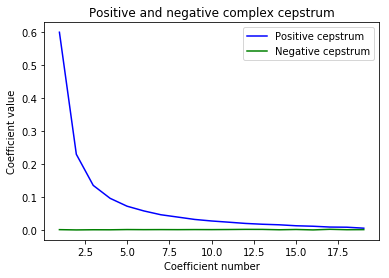

In [3]:
posceps, negceps = complex_cepstrum(np.fft.fft(u),np.fft.fft(y))

fig, ax = plt.subplots()
ax.set_xlabel('Coefficient number')
ax.set_ylabel('Coefficient value')
ax.plot(np.arange(1,20),posceps[1:20],'b', label='Positive cepstrum')
ax.plot(np.arange(1,20),negceps[1:20],'g', label='Negative cepstrum')
ax.legend()
plt.title('Positive and negative complex cepstrum')

The code below saves the data from the figure above to be imported into LaTeX. Uncomment if you want this file.

In [4]:
#import csv
#with open('minimumcepstrum.csv', 'w', newline='') as f:
#    writer = csv.writer(f)
#    writer.writerows(np.column_stack((np.arange(-20,21),np.concatenate((negceps[20:0:-1],posceps[0:21])))))

We can now easily assess whether the signals we are looking at come from a minimum or mixed phase stable system: If the <font color='green'>green line</font> is zero, the system is minimum-phase. If it is not, the system is mixed-phase. The maximum-phase case results in numerical issues in calculating the fft's (as the signals are unbounded). We will illustrate the results from the manuscript, however, by starting from frequency domain data.

In what follows, we will show the equivalences between the norm calculated from cepstral coefficients and the norm calculated from subspace angles, in the minimum-phase. We will thus illustrate *Equation (36)*.

### Stable, minimum-phase systems

We implement the necessary steps to verify *Equation (36)* with an example of a stable, minimum-phase system that fulfills the assumptions made in the paper.

Again, we first initialize the system and generate input-output data. This is  a copy of the code in the previous section, with the non-minimum phase examples removed.

In [5]:
np.random.seed(seed=0)   # Initialize the random number generator to get consistent results. Turn this off
                         # if you want to experiment with other sequences of random numbers.

N=2**14        # N is the length of the time series. The longer it is, the more reliable the estimates of the spectra will be.
order = 6       # order is the order of the system of which we want to calculate the norm.
fs=10**6        # fs is the sampling frequency of the system.


# Define poles and zeros. Commented out are several approaches for defining them, other than throwing random numbers.
# It is important that these arrays are of the same length. If there is a mismatch between the amount of poles and zeros,
# zeros or poles in 0 can be added as appropriate (for the minimum-phase part, for the maximum-phase part, add zeros
# and poles in infinity).

    # The next three lines contain a random, stable, minimum-phase system.
#poles = np.random.rand(order)   # poles contains the poles of the system.
#zeros = np.random.rand(order)   # zeros contains the zeros of the system.
#k = 1                           # k is the gain of the system.

    # The next three lines contain an example of a stable, minimum-phase system.
zeros = [0.8, 0.6, 0]
poles = [0.9, 0.7, 0.4]
k = 1

sys = sps.ZerosPolesGain(zeros, poles, k, dt=1/fs)   # Initialize the system

# Generate input data. The current set-up is to put a white noise signal through a fifth-order system to color it.
# Different ways of generating input data can be experimented with here.

u = np.random.randn(N)
tu,u = sps.dlsim(sps.ZerosPolesGain(np.random.rand(3), np.random.rand(3), 1,dt=1/fs),u)
u = u[:,0]

# Generate output data by doing a simulation of the system created above, and driving it with the input created above.
ty,y = sps.dlsim(sys,u)
y = y[:,0]

We can estimate the power cepstrum of and the subspace angles related to the underlying system with the functions *power_cepstrum* and *subspace_angles*, implemented above. They calculate respectively the *c<sub>h</sub>(k)*, as explained in *Appendix A.2 Computing the power cepstrum*, and the cosines of the angles as explained in *Appendix B.2 Computing the range of the observability matrix* and *Equations (20)* and *(21)*. We now calculate both sides of *Equation (36)*, and show they are the same.

In [6]:
powerceps = power_cepstrum(u,y)  # Estimate the power cepstral coefficients of the underlying system.

powercepslength = int(np.floor(powerceps.shape[0]/2))   # This is the length of one side of the power cepstrum.                
weights = np.arange(0,powercepslength)  # Initialize the weights
powercepstraldistance = np.dot(weights,np.square(powerceps[:powercepslength]))  # Calculate the right-hand side of Equation (36).

cosangles = subspace_angles(u,y)  # Estimate the cosines of the angles of the underlying system.
anglesdistance = -2*np.log(np.prod(cosangles))  # Calculate the left-hand side of Equation (26).

poleszerosdistance = poles_zeros_norm(poles,zeros)

print("The subspace angles norm of the underlying system equals",anglesdistance,".")
print("The weighted cepstral norm of the underlying system equals",powercepstraldistance,".")
print("The true norm, calculated from poles and zeros equals", poleszerosdistance,".")
print()
print("The difference between the weighted cepstral norm and the subspace angles norm is",np.absolute(powercepstraldistance - anglesdistance),".")
print()
print("The difference between the true norm and the weighted cepstral norm is",np.absolute(powercepstraldistance - poleszerosdistance),".")
print("The difference between the true norm and the subspace angle norm is",np.absolute(anglesdistance - poleszerosdistance),".")


The subspace angles norm of the underlying system equals 0.671704279419 .
The weighted cepstral norm of the underlying system equals 0.671818570022 .
The true norm, calculated from poles and zeros equals 0.671704279418 .

The difference between the weighted cepstral norm and the subspace angles norm is 0.000114290603161 .

The difference between the true norm and the weighted cepstral norm is 0.000114290603364 .
The difference between the true norm and the subspace angle norm is 2.02726724297e-13 .


Note that they are not exactly equal, as they would only be exactly equal in the case of infintely good estimations of both cepstral coefficients and subspace angles. However, the difference between them is several orders smaller than the absolute value of the norms, which is good enough to use in practice, and illustrates the equivalence shown in the paper.

By changing the value of the signal length, *N*, above, you should see that, the longer the time series, the smaller the difference between the two usually is, as for longer time series, the estimate of the cepstral coefficients is better. Note that *subspace_angles* only takes into account the first 2<sup>10</sup> time steps, to keep the computational burden small. Even better results could be obtained by using the full time series to estimate subspace angles.

## Starting from frequency domain data (i.e. spectra)

### Assessing phase-type of a signal

In the case of unstable systems, the input and output signals are unbounded. Fortunately, we can redo the analysis above, starting from frequency domain data, and illustrate the unstable maximum-phase case in that way.

We first initialize any system and generate input-output spectra:

In [7]:
np.random.seed(seed=0)   # Initialize the random number generator to get consistent results. Turn this off
                         # if you want to experiment with other sequences of random numbers.

N=2**14     # N is the length of the time series. The longer it is, the more reliable the estimates of the spectra will be.
            # In this case, this is only used to estimate an input u. We start from the time domain, to allow users to employ
            # the same signals as in the previous code blocks. 
order = 6   # order is the order of the system of which we want to calculate the norm.
fs=10**6    # fs is the sampling frequency of the system.


# Define poles and zeros. Commented out are several approaches for defining them, other than throwing random numbers.
# It is important that these arrays are of the same length. If there is a mismatch between the amount of poles and zeros,
# zeros or poles in 0 can be added as appropriate (for the minimum-phase part, for the maximum-phase part, add zeros
# and poles in infinity).

    # The next three lines contain a random, stable, minimum-phase system.
#poles = 0.9*np.random.rand(order)   # poles contains the poles of the system.
#zeros = 0.9*np.random.rand(order)   # zeros contains the zeros of the system.
#k = 1                           # k is the gain of the system.

    # The next three lines contain a random mixed-phase system.
    # Invert this (see below) to get a maximum-phase system.
#amount_of_minimum_phase_poles = np.random.randint(1,order)
#poles = [*np.random.rand(amount_of_minimum_phase_poles), *(1/np.random.rand(order-amount_of_minimum_phase_poles))]
#amount_of_minimum_phase_zeros = np.random.randint(1,order)
#zeros = [*np.random.rand(amount_of_minimum_phase_zeros), *(1/np.random.rand(order-amount_of_minimum_phase_zeros))]
#k = 1

    # The next three lines contain a random, stable, minimum-phase system. The poles and zeros can be inverted 
    # later on (see below) to generate a random, unstable, maximum-phase systems.
zeros = [0.8, 0.6, 10**(-15)]   # If you put in a zero here, you will not be able to invert the phase-type of the
                                # system by inverting the poles and zeros, as that would result in dividing by zero.
                                # We solve this by taking a very small number instead.
poles = [0.9, 0.7, 0.4]
k = 1

    # The next three lines contain an example of a mixed-phase system.
#zeros = [1/0.8, 0.6, 10**(-15)]
#poles = [0.9, 0.7, 1/0.4]
#k = 1

    # The next two lines invert the phase-type of the system. You can use this to see that the positive and negative
    # part of the complex cepstrum are indeed representing the minimum and maximum phase part of the signals.
zeros = [1 / x for x in zeros]
poles = [1 / x for x in poles]

sys = sps.ZerosPolesGain(zeros, poles, k, dt=1/fs)   # Initialize the system

# Generate input data. The current set-up is to put a white noise signal through a fifth-order system to color it,
# and then calculate the spectrum of this signal. Of course, you can just as well start from a specific input spectrum.
# Different ways of generating input data can be experimented with here.
u = np.random.randn(N)
tin,u = sps.dlsim(sps.ZerosPolesGain(np.random.rand(5), np.random.rand(5), 1,dt=1/fs),u)
u = u[:,0]
frequ = np.fft.fft(u)
wu = np.fft.fftfreq(N,d=1/fs)                       # Find the frequencies at which the fft samples the spectrum,
                                                    # so we can sample the system at the same frequencies.
                                                    # Note that if you start directly from an input spectrum,
                                                    # you should provide the frequencies at which this spectrum
                                                    # was sampled to wu.
                
wsys, freqsys = sps.dfreqresp(sys,wu*2*np.pi/fs)    # Sample the system in the frequency domain.
freqy = freqsys*frequ                               # Calculate the output spectrum.

Next, we calculate the complex cepstrum of the system, and plot the first few coefficients of the <font color='blue'>positive part in blue</font>, and the first few coefficients of the <font color='green'>negative part in green</font>.

* The zeroth coefficient says something about initial state and gain of the system, and is irrelevant for our purposes. We will therefore not show it in the plots below. 
* The other positive coefficients <font color='blue'>(the blue line in the plot below)</font> should be zero in the (unstable) maximum-phase case, and non-zero in the (stable) minimum-phase case. In the mixed-phase case, they contain the (stable) minimum-phase part of the system.
* The other negative coefficients <font color='green'>(the green line in the plot below)</font> should be zero in the (stable) minimum-phase case, and non-zero in the (unstable) maximum-phase case. In the mixed-phase case, they contain the (unstable) maximum-phase part of the system.

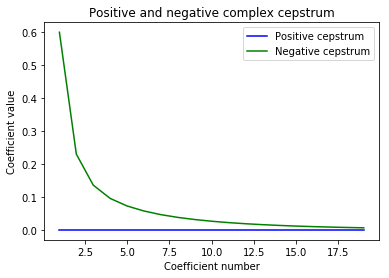

In [8]:
posceps, negceps = complex_cepstrum(frequ,freqy)

fig, ax = plt.subplots()
ax.set_xlabel('Coefficient number')
ax.set_ylabel('Coefficient value')
ax.plot(np.arange(1,20),posceps[1:20],'b', label='Positive cepstrum')
ax.plot(np.arange(1,20),negceps[1:20],'g', label='Negative cepstrum')
ax.legend()
plt.title('Positive and negative complex cepstrum')

The code below saves the data from the figure above to be imported into LaTeX. Uncomment if you want this file.

In [9]:
#import csv
#with open('maximumcepstrum.csv', 'w', newline='') as f:
#    writer = csv.writer(f)
#    writer.writerows(np.column_stack((np.arange(-20,21),np.concatenate((negceps[20:0:-1],posceps[0:21])))))

We can now easily assess whether the signals we are looking at come from a minimum or mixed phase stable system: If the <font color='green'>green line</font> is zero, the system is minimum-phase. If the <font color='blue'>blue line</font> is zero, the system is maximum-phase. Otherwise, it is mixed-phase.

In what follows, we will show the equivalences between the norm calculated from cepstral coefficients and the norm calculated from subspace angles. We will thus illustrate *Equation (36)* and *(45)*.

### Unstable, maximum-phase systems

We implement the necessary steps to verify *Equation (45)* with any example of an unstable, maximum-phase system that fulfills the assumptions made in the paper.

Again, we first initialize the system and generate input-output spectral data. This is  a copy of the code in the previous section, with the non-maximum phase examples removed.

The *FORSE* method we use to estimate the subspace angles appears to be very sensitive to poles and zeros near the unit circle. We therefore multiply all random numbers thrown to generate poles and zeros by 0.9.

In [10]:
np.random.seed(seed=0)   # Initialize the random number generator to get consistent results. Turn this off
                         # if you want to experiment with other sequences of random numbers.

N=2**14     # N is the length of the time series. The longer it is, the more reliable the estimates of the spectra will be.
            # In this case, this is only used to estimate an input u. We start from the time domain, to allow users to employ
            # the same signals as in the previous code blocks. 
order = 6   # order is the order of the system of which we want to calculate the norm.
fs=10**4    # fs is the sampling frequency of the system.


# Define poles and zeros. Commented out are several approaches for defining them, other than throwing random numbers.
# It is important that these arrays are of the same length. If there is a mismatch between the amount of poles and zeros,
# zeros or poles in 0 can be added as appropriate (for the minimum-phase part, for the maximum-phase part, add zeros
# and poles in infinity).

    # The next three lines contain a random, stable, minimum-phase system. The poles and zeros can be inverted 
    # later on (see below) to generate a random, unstable, maximum-phase systems.
poles = 0.9*np.random.rand(order)   # poles contains the poles of the system.
zeros = 0.9*np.random.rand(order)   # zeros contains the zeros of the system.
k = 1                           # k is the gain of the system.

    # The next three lines contain an example of a stable, minimum-phase system.
#zeros = [0.8, 0.6, 10**(-15)]   # If you put in a zero here, you will not be able to invert the phase-type of the
                                # system by inverting the poles and zeros, as that would result in dividing by zero.
                                # We solve this by taking a very small number instead.
#poles = [0.9, 0.7, 0.4]
#k = 1

    # The next two lines invert the phase-type of the system.
zeros = [1 / x for x in zeros]
poles = [1 / x for x in poles]

sys = sps.ZerosPolesGain(zeros, poles, k, dt=1/fs)   # Initialize the system

# Generate input data. The current set-up is to put a white noise signal through a fifth-order system to color it,
# and then calculate the spectrum of this signal. Of course, you can just as well start from a specific input spectrum.
# Different ways of generating input data can be experimented with here.
u = np.random.randn(N)
tin,u = sps.dlsim(sps.ZerosPolesGain(0.9*np.random.rand(5), 0.9*np.random.rand(5), 1,dt=1/fs),u)
u = u[:,0]
frequ = np.fft.fft(u)
wu = np.fft.fftfreq(N,d=1/fs)                       # Find the frequencies at which the fft samples the spectrum,
                                                    # so we can sample the system at the same frequencies.
                                                    # Note that if you start directly from an input spectrum,
                                                    # you should provide the frequencies at which this spectrum
                                                    # was sampled to wu.
                
wsys, freqsys = sps.dfreqresp(sys,wu*2*np.pi/fs)    # Sample the system in the frequency domain.
freqy = freqsys*frequ                               # Calculate the output spectrum.

We can estimate the power cepstrum of the underlying system directly from the spectral data and the subspace angles with the function *FORSE*, implemented above. This gives us respectively the *c<sub>h</sub>(k)*, as explained in *Appendix A.2 Computing the power cepstrum*, and the cosines of the angles as explained in *Appendix B.2 Computing the range of the observability matrix* and *Equations (20)* and *(21)*. We now calculate both sides of *Equation (45)*, and show they are the same.

In [11]:
psd=np.absolute(freqy/frequ)                  # Estimate the power cepstral coefficients of the underlying system.
powerceps = np.fft.ifft(2*np.log(psd)).real  

powercepslength = int(np.floor(powerceps.shape[0]/2))   # This is the length of one side of the power cepstrum.        
weights = np.arange(0,powercepslength)  # Initialize the weights
powercepstraldistance = np.dot(weights,np.square(powerceps[:powercepslength]))  # Calculate the left-hand side of Equation (45).

order = len(poles)
cosangles = FORSE(frequ,freqy,wu*2*np.pi/fs)    # Calculate the cosines of the subspace angles.
anglesdistance = -2*np.log(np.prod(cosangles))  # Calculate the right-hand side of Equation (31).

poleszerosdistance = poles_zeros_norm(poles,zeros)

print("The subspace angles norm of the underlying system equals",anglesdistance,".")
print("The weighted cepstral norm of the underlying system equals",powercepstraldistance,".")
print("The true norm, calculated from poles and zeros equals", poleszerosdistance,".")
print()
print("The difference between the weighted cepstral norm and the subspace angles norm is",np.absolute(powercepstraldistance - anglesdistance),".")
print()
print("The difference between the true norm and the weighted cepstral norm is",np.absolute(powercepstraldistance - poleszerosdistance),".")
print("The difference between the true norm and the subspace angle norm is",np.absolute(anglesdistance - poleszerosdistance),".")


The subspace angles norm of the underlying system equals 1.20686878795 .
The weighted cepstral norm of the underlying system equals 1.2060008794 .
The true norm, calculated from poles and zeros equals 1.2060008794 .

The difference between the weighted cepstral norm and the subspace angles norm is 0.00086790854291 .

The difference between the true norm and the weighted cepstral norm is 2.22044604925e-15 .
The difference between the true norm and the subspace angle norm is 0.000867908542908 .


The *FORSE* algorithm does not appear to be very robust to poles or zeros near the unit circle. However, experimenting a few times, we can see that both sides of the equation are in good agreement.